In [1]:
%matplotlib inline

import numpy as np
import geopandas as gpd
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams['figure.figsize'] =10, 8


## Import Shapefiles

In this case I looked for a couple of types of data: vector polygons based on county lines and point data. In this demo we are going to explore doing spatial and attribute joins and then do some data exploration once they are all combined.

http://geodata.vermont.gov/datasets/VTANR::public-water-sources?geometry=-77.941%2C43.059%2C-67.477%2C44.448
            
http://geodata.vermont.gov/datasets/VTANR::water-quality-monitoring-sites?geometry=-75.374%2C43.89%2C-70.142%2C44.579


In [2]:
census = gpd.read_file('/VT_2000_Census_County_Boundaries_and_Statistics.shp', vfs='zip://VT_2000_Census_County_Boundaries_and_Statistics.zip')
health1 = gpd.read_file('/VT_County_Health_Data_19862000__1.shp', vfs='zip://VT_County_Health_Data_19862000__1.zip')
health2 = gpd.read_file('/VT_County_Health_Data_19862000__2.shp', vfs='zip://VT_County_Health_Data_19862000__2.zip')
waterqlt = gpd.read_file('/Water_Quality_Monitoring_Sites.shp', vfs='zip://Water_Quality_Monitoring_Sites.zip')

## CRS and Datums
First check that the shapefiles are using the same projections, otherwise spatial merges can go quite wrong

In [5]:
print(census.crs)
print(waterqlt.crs)


{'proj': 'tmerc', 'lat_0': 42.5, 'lon_0': -72.5, 'k': 0.999964286, 'x_0': 500000, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}
{'proj': 'tmerc', 'lat_0': 42.5, 'lon_0': -72.5, 'k': 0.999964286, 'x_0': 500000, 'y_0': 0, 'datum': 'NAD83', 'units': 'm', 'no_defs': True}


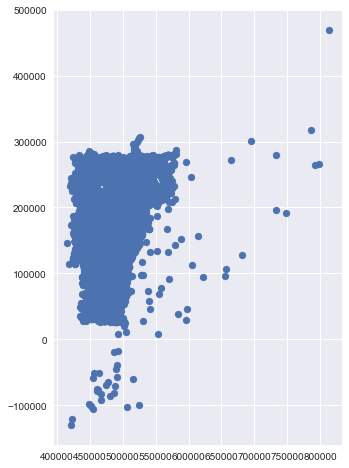

In [6]:
waterqlt.plot()

In [7]:
# another way to check if they are using teh same
census.crs == waterqlt.crs

True

In [8]:
#print(health1.crs)

When I check the health datasets they do not have a crs and instead return an error, but they do have polygons. In this case I will merge the data based on location name rather than spatial coordinates.

In [9]:
census.head()

,OBJECTID,FIPSSTCO,STATE,COUNTY,OID_,STFID,POP2000,WHITE,BLACK,AMERI_ES,...,AVE_FAM_SZ,HSE_UNITS,URBAN,RURAL,VACANT,OWNER_OCC,RENTER_OCC,SHAPESTAre,SHAPESTLen,geometry
0,1,50001,Vermont,Addison,0,50001,35974,34844,196,93,...,3.02,15312,0,0,2244,9782,3286,2.093455e+09,224144.316819,"POLYGON ((471110.1172867668 152350.9054984394,..."
1,2,50003,Vermont,Bennington,1,50003,36994,36161,155,74,...,2.91,19403,0,0,4557,10599,4247,1.755100e+09,215455.471387,"POLYGON ((436337.1072635216 37330.0554193073, ..."
2,3,50005,Vermont,Caledonia,2,50005,29702,28954,87,163,...,2.95,14504,0,0,2841,8499,3164,1.702881e+09,254119.336311,(POLYGON ((516165.9173180934 187054.0355226113...
3,4,50007,Vermont,Chittenden,3,50007,146571,139446,1328,403,...,3.02,58864,0,0,2412,37292,19160,1.604814e+09,202393.239094,"POLYGON ((453514.1172740302 241227.2455603733,..."
4,5,50009,Vermont,Essex,4,50009,6459,6237,11,41,...,2.92,4762,0,0,2160,2069,533,1.744999e+09,266955.505549,"POLYGON ((574943.5073595017 233740.7855550044,..."


In [10]:
waterqlt.head()

,LocationID,Name,Latitude,Longitude,Descriptio,WBID,BioSiteID,RM,LakeID,BugAssessm,FishAssess,WQData,HabitatDat,ReportURL,geometry
0,502000,Mill Brook,44.45639,-73.01194,Located upstream of bridge on Tarbox Rd.,VT08-04,491300000006,0.6,None,0,0,Yes,Yes,https://anrweb.vt.gov/DEC/IWIS/ReportViewer.as...,POINT (459260.0334506461 217478.7768885082)
1,502001,Mill Brook,44.44472,-72.97639,Located immediately above 3rd bridge.,VT08-04,491300000027,2.7,None,NA,0,Yes,Yes,https://anrweb.vt.gov/DEC/IWIS/ReportViewer.as...,POINT (462077.7666572685 216161.6401144274)
2,502002,Mill Brook,44.44528,-72.97472,Located below 4th bridge.,VT08-04,491300000028,2.8,None,NA,0,Yes,Yes,https://anrweb.vt.gov/DEC/IWIS/ReportViewer.as...,POINT (462213.4766775466 216227.5238393181)
3,502003,Huntington River,44.30723,-72.98305,"Adjacent to Huntington-Huntington Center Road,...",VT08-10,492300000106,10.6,None,0,NA,Yes,Yes,https://anrweb.vt.gov/DEC/IWIS/ReportViewer.as...,POINT (461462.3162371466 200886.3130167034)
4,502004,John Brook,44.34222,-72.96833,Located above bridge crossing Happy Hollow Rd.,VT08-10,492303000023,2.3,None,0,NA,Yes,Yes,https://anrweb.vt.gov/DEC/IWIS/ReportViewer.as...,POINT (462657.4162855234 204768.5256248628)


In [11]:
print(census.shape)
print(waterqlt.shape)

(14, 47)
(9988, 15)


In [12]:
cenwat = gpd.sjoin(waterqlt, census, how="inner", op='within')

The op options determines the type of join operation to apply. op can be set to “intersects”, “within” or “contains” (these are all equivalent when joining points to polygons, but differ when joining polygons to other polygons or lines).

In [13]:
cenwat.shape

(9692, 62)

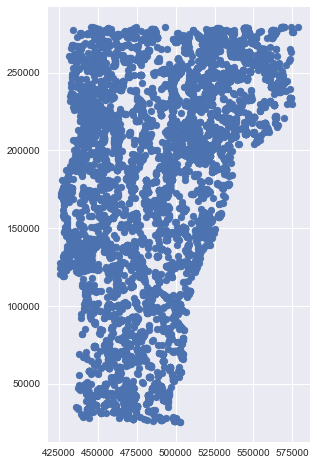

In [14]:
cenwat.plot()

In [15]:
cenwat.head(5)

,LocationID,Name,Latitude,Longitude,Descriptio,WBID,BioSiteID,RM,LakeID,BugAssessm,...,FAMILIES,AVE_FAM_SZ,HSE_UNITS,URBAN,RURAL,VACANT,OWNER_OCC,RENTER_OCC,SHAPESTAre,SHAPESTLen
0,502000,Mill Brook,44.45639,-73.01194,Located upstream of bridge on Tarbox Rd.,VT08-04,491300000006,0.6,None,0,...,35168,3.02,58864,0,0,2412,37292,19160,1.604814e+09,202393.239094
1,502001,Mill Brook,44.44472,-72.97639,Located immediately above 3rd bridge.,VT08-04,491300000027,2.7,None,NA,...,35168,3.02,58864,0,0,2412,37292,19160,1.604814e+09,202393.239094
2,502002,Mill Brook,44.44528,-72.97472,Located below 4th bridge.,VT08-04,491300000028,2.8,None,NA,...,35168,3.02,58864,0,0,2412,37292,19160,1.604814e+09,202393.239094
3,502003,Huntington River,44.30723,-72.98305,"Adjacent to Huntington-Huntington Center Road,...",VT08-10,492300000106,10.6,None,0,...,35168,3.02,58864,0,0,2412,37292,19160,1.604814e+09,202393.239094
4,502004,John Brook,44.34222,-72.96833,Located above bridge crossing Happy Hollow Rd.,VT08-10,492303000023,2.3,None,0,...,35168,3.02,58864,0,0,2412,37292,19160,1.604814e+09,202393.239094


In [16]:
cenwat.columns

Index(['LocationID', 'Name', 'Latitude', 'Longitude', 'Descriptio', 'WBID',
       'BioSiteID', 'RM', 'LakeID', 'BugAssessm', 'FishAssess', 'WQData',
       'HabitatDat', 'ReportURL', 'geometry', 'index_right', 'OBJECTID',
       'FIPSSTCO', 'STATE', 'COUNTY', 'OID_', 'STFID', 'POP2000', 'WHITE',
       'BLACK', 'AMERI_ES', 'ASIAN', 'HAWN_PI', 'OTHER', 'MULT_RACE',
       'HISPANIC', 'MALES', 'FEMALES', 'AGE_UNDER5', 'AGE_5_17', 'AGE_18_21',
       'AGE_22_29', 'AGE_30_39', 'AGE_40_49', 'AGE_50_64', 'AGE_65_UP',
       'MED_AGE', 'MED_AGE_M', 'MED_AGE_F', 'HOUSEHOLDS', 'AVE_HH_SZ',
       'HSEHLD_1_M', 'HSEHLD_1_F', 'MARHH_CHD', 'MARHH_NO_C', 'MHH_CHILD',
       'FHH_CHILD', 'FAMILIES', 'AVE_FAM_SZ', 'HSE_UNITS', 'URBAN', 'RURAL',
       'VACANT', 'OWNER_OCC', 'RENTER_OCC', 'SHAPESTAre', 'SHAPESTLen'],
      dtype='object')

Now all of the locations for water also contain population data for the county, something that might be useful for analysis of impact. 

## Attribute Merge

Sometimes you need to merge based on something other than geometry. In this case you need a common key between the two datasets. In the case of the census and the health1 it is county.

In [17]:
health1.head()

,OBJECTID,CNTYNAME,CNTYFIPS,TUBR1997,MEAS1997,VHEP1997,SYPH1997,MNEO1997,LEUK1997,BNEO1997,...,MDS61997,MDS71997,MDS81997,MDS91997,MDSO1997,MDST1997,MDUR1997,SHAPESTAre,SHAPESTLen,geometry
0,1,ESSEX,9,0,0,0,0,19,0,1,...,0,0,0,0,0,0,0,1.742019e+09,273976.376341,"POLYGON ((547354.6900133285 278818.4100803561,..."
1,2,FRANKLIN,11,0,0,0,0,89,2,4,...,1,0,0,0,1,1,1,1.792344e+09,186302.287654,"POLYGON ((445428.2199842055 279488.6900805449,..."
2,3,GRAND ISLE,13,0,0,1,0,10,0,0,...,0,0,0,0,0,0,0,5.036918e+08,131216.935453,"POLYGON ((433753.5599808663 272277.8400784798,..."
3,4,ORLEANS,19,0,0,0,0,53,2,0,...,0,0,0,0,2,0,0,1.870489e+09,209742.900339,"POLYGON ((495785.6599985936 278662.0600803122,..."
4,5,LAMOILLE,15,0,0,0,0,45,2,0,...,0,0,0,0,2,0,1,1.198783e+09,163591.156113,"POLYGON ((466352.3099901846 237070.7300683906,..."


In [18]:
census.head()

,OBJECTID,FIPSSTCO,STATE,COUNTY,OID_,STFID,POP2000,WHITE,BLACK,AMERI_ES,...,AVE_FAM_SZ,HSE_UNITS,URBAN,RURAL,VACANT,OWNER_OCC,RENTER_OCC,SHAPESTAre,SHAPESTLen,geometry
index_right,,,,,,,,,,,,,,,,,,,,,
0,1,50001,Vermont,Addison,0,50001,35974,34844,196,93,...,3.02,15312,0,0,2244,9782,3286,2.093455e+09,224144.316819,"POLYGON ((471110.1172867668 152350.9054984394,..."
1,2,50003,Vermont,Bennington,1,50003,36994,36161,155,74,...,2.91,19403,0,0,4557,10599,4247,1.755100e+09,215455.471387,"POLYGON ((436337.1072635216 37330.0554193073, ..."
2,3,50005,Vermont,Caledonia,2,50005,29702,28954,87,163,...,2.95,14504,0,0,2841,8499,3164,1.702881e+09,254119.336311,(POLYGON ((516165.9173180934 187054.0355226113...
3,4,50007,Vermont,Chittenden,3,50007,146571,139446,1328,403,...,3.02,58864,0,0,2412,37292,19160,1.604814e+09,202393.239094,"POLYGON ((453514.1172740302 241227.2455603733,..."
4,5,50009,Vermont,Essex,4,50009,6459,6237,11,41,...,2.92,4762,0,0,2160,2069,533,1.744999e+09,266955.505549,"POLYGON ((574943.5073595017 233740.7855550044,..."


What becomes obvious at first is that the names of the county column is different, so that has to be corrects first with a quick change to make them the same.

In [19]:
health1 = health1.rename(columns={'CNTYNAME': 'COUNTY'})
health1.head(1)

,OBJECTID,COUNTY,CNTYFIPS,TUBR1997,MEAS1997,VHEP1997,SYPH1997,MNEO1997,LEUK1997,BNEO1997,...,MDS61997,MDS71997,MDS81997,MDS91997,MDSO1997,MDST1997,MDUR1997,SHAPESTAre,SHAPESTLen,geometry
0,1,ESSEX,9,0,0,0,0,19,0,1,...,0,0,0,0,0,0,0,1.742019e+09,273976.376341,"POLYGON ((547354.6900133285 278818.4100803561,..."


The first time I ran the merge I got all the headers but no data, it took a second to realized capitlization was interfering with the merges. Make sure your matching data truly matches otherwise you may accidently leave things on the table.

In [20]:
county = census['COUNTY']
census['COUNTY'] = county.str.upper()
census.head(1)

,OBJECTID,FIPSSTCO,STATE,COUNTY,OID_,STFID,POP2000,WHITE,BLACK,AMERI_ES,...,AVE_FAM_SZ,HSE_UNITS,URBAN,RURAL,VACANT,OWNER_OCC,RENTER_OCC,SHAPESTAre,SHAPESTLen,geometry
index_right,,,,,,,,,,,,,,,,,,,,,
0,1,50001,Vermont,ADDISON,0,50001,35974,34844,196,93,...,3.02,15312,0,0,2244,9782,3286,2.093455e+09,224144.316819,"POLYGON ((471110.1172867668 152350.9054984394,..."


In [21]:
cenhealth = census.merge(health1, on='COUNTY')

The data is now merged! There are ways to specify the join types and the like, but for now this is a good way to start.

In [22]:
cenhealth.columns

Index(['OBJECTID_x', 'FIPSSTCO', 'STATE', 'COUNTY', 'OID_', 'STFID', 'POP2000',
       'WHITE', 'BLACK', 'AMERI_ES',
       ...
       'MDS61997', 'MDS71997', 'MDS81997', 'MDS91997', 'MDSO1997', 'MDST1997',
       'MDUR1997', 'SHAPESTAre_y', 'SHAPESTLen_y', 'geometry_y'],
      dtype='object', length=268)

In [23]:
cenhealth.shape

(14, 268)

In [24]:
cenhealth.head()

,OBJECTID_x,FIPSSTCO,STATE,COUNTY,OID_,STFID,POP2000,WHITE,BLACK,AMERI_ES,...,MDS61997,MDS71997,MDS81997,MDS91997,MDSO1997,MDST1997,MDUR1997,SHAPESTAre_y,SHAPESTLen_y,geometry_y
0,1,50001,Vermont,ADDISON,0,50001,35974,34844,196,93,...,0,0,0,0,1,0,2,2.092367e+09,228860.331938,"POLYGON ((434796.7799811655 196301.6400567106,..."
1,2,50003,Vermont,BENNINGTON,1,50003,36994,36161,155,74,...,0,1,0,0,3,0,2,1.754463e+09,214912.601791,"POLYGON ((438785.3099823041 90756.64002647823,..."
2,3,50005,Vermont,CALEDONIA,2,50005,29702,28954,87,163,...,0,0,0,0,2,0,1,1.703932e+09,255482.252474,"POLYGON ((544385.4400124804 252290.4700727548,..."
3,4,50007,Vermont,CHITTENDEN,3,50007,146571,139446,1328,403,...,1,0,1,3,19,3,9,1.604059e+09,203203.731722,"POLYGON ((442257.689983299 247214.0600712991, ..."
4,5,50009,Vermont,ESSEX,4,50009,6459,6237,11,41,...,0,0,0,0,0,0,0,1.742019e+09,273976.376341,"POLYGON ((547354.6900133285 278818.4100803561,..."


## Merging and analyzing

One of the intersting parts of geospatial data is merging and then analyzing the data

In [25]:
# since the name was already changed in health1 it needs to be changed here too
health2 = health2.rename(columns={'CNTYNAME': 'COUNTY'})
health2

,OBJECTID,COUNTY,CNTYFIPS,TLBW1988,TLBW1989,TLBW1990,TLBW1991,TLBW1992,TLBW1993,TLBW1994,...,OHP1998,OHP1999,OHP2000,UNMG2000,DLCS2000,ANM2000,CPFS1999,SHAPESTAre,SHAPESTLen,geometry
0,1,ESSEX,9,7,3,3,6,7,6,3,...,9.3,5.7,11.900000,35.599998,0.000000,0.6,22.100000,1.742019e+09,273976.376341,"POLYGON ((547354.6873402984 278818.4055869313,..."
1,2,FRANKLIN,11,22,53,3,46,45,41,45,...,8.9,10.2,13.500000,59.400002,69.599998,4.6,14.100000,1.792344e+09,186302.287654,"POLYGON ((445428.2172680789 279488.6855872976,..."
2,3,GRAND ISLE,13,6,5,3,6,2,4,3,...,11.8,8.4,12.900000,22.799999,22.799999,1.6,13.000000,5.036918e+08,131216.935453,"POLYGON ((433753.55725986 272277.8355821182, 4..."
3,4,ORLEANS,19,26,18,22,24,24,23,17,...,11.2,15.6,13.400000,35.700001,32.700001,2.4,23.900000,1.870489e+09,209742.900339,"POLYGON ((495785.6573037624 278662.0555869097,..."
4,5,LAMOILLE,15,18,18,19,12,6,10,23,...,7.3,9.4,7.800000,25.900000,51.700001,4.4,13.000000,1.198783e+09,163591.156113,"POLYGON ((466352.3072830908 237070.7255575176,..."
5,6,CALEDONIA,5,19,33,13,12,14,25,28,...,16.9,13.2,10.000000,30.900000,54.099998,3.9,18.600000,1.703932e+09,255482.252474,"POLYGON ((544385.4373380811 252290.4655682262,..."
6,7,CHITTENDEN,7,107,106,108,101,109,108,102,...,4.2,6.7,7.800000,46.200001,66.800003,4.5,10.100000,1.604059e+09,203203.731722,"POLYGON ((442257.6872660585 247214.0555645131,..."
7,8,WASHINGTON,23,44,33,44,53,38,36,47,...,12.6,12.9,11.400000,13.100000,71.400002,3.0,12.300000,1.801757e+09,212915.133188,"POLYGON ((505289.5573104972 222839.8555476221,..."
8,9,ADDISON,1,20,27,31,37,21,23,28,...,4.7,3.8,4.400000,36.700001,39.000000,2.6,10.100000,2.092367e+09,228860.331938,"POLYGON ((434796.777261198 196301.6355287833, ..."
9,10,ORANGE,17,21,25,15,18,15,20,21,...,9.0,7.2,6.800000,13.500000,21.500000,5.3,13.400000,1.792061e+09,208061.928325,"POLYGON ((480628.2472933284 169939.8755106765,..."


In [26]:
healthtot = health2.merge(health1, on='COUNTY')

In [27]:
healthtot.shape

(14, 426)

Now the two large datasets are merged into one larger one. At this point it still have geometry data but in order to seperate trends and do some analysis we need to transpose the dataframe

In [28]:
healthtot.head(9)

,OBJECTID_x,COUNTY,CNTYFIPS_x,TLBW1988,TLBW1989,TLBW1990,TLBW1991,TLBW1992,TLBW1993,TLBW1994,...,MDS61997,MDS71997,MDS81997,MDS91997,MDSO1997,MDST1997,MDUR1997,SHAPESTAre_y,SHAPESTLen_y,geometry_y
0,1,ESSEX,9,7,3,3,6,7,6,3,...,0,0,0,0,0,0,0,1.742019e+09,273976.376341,"POLYGON ((547354.6900133285 278818.4100803561,..."
1,2,FRANKLIN,11,22,53,3,46,45,41,45,...,1,0,0,0,1,1,1,1.792344e+09,186302.287654,"POLYGON ((445428.2199842055 279488.6900805449,..."
2,3,GRAND ISLE,13,6,5,3,6,2,4,3,...,0,0,0,0,0,0,0,5.036918e+08,131216.935453,"POLYGON ((433753.5599808663 272277.8400784798,..."
3,4,ORLEANS,19,26,18,22,24,24,23,17,...,0,0,0,0,2,0,0,1.870489e+09,209742.900339,"POLYGON ((495785.6599985936 278662.0600803122,..."
4,5,LAMOILLE,15,18,18,19,12,6,10,23,...,0,0,0,0,2,0,1,1.198783e+09,163591.156113,"POLYGON ((466352.3099901846 237070.7300683906,..."
5,6,CALEDONIA,5,19,33,13,12,14,25,28,...,0,0,0,0,2,0,1,1.703932e+09,255482.252474,"POLYGON ((544385.4400124804 252290.4700727548,..."
6,7,CHITTENDEN,7,107,106,108,101,109,108,102,...,1,0,1,3,19,3,9,1.604059e+09,203203.731722,"POLYGON ((442257.689983299 247214.0600712991, ..."
7,8,WASHINGTON,23,44,33,44,53,38,36,47,...,0,0,0,1,5,0,3,1.801757e+09,212915.133188,"POLYGON ((505289.5600013079 222839.8600643154,..."
8,9,ADDISON,1,20,27,31,37,21,23,28,...,0,0,0,0,1,0,2,2.092367e+09,228860.331938,"POLYGON ((434796.7799811655 196301.6400567106,..."


In [29]:
del healthtot['OBJECTID_x']

Now it is time to transpose the dataset so we can start sorting and qualifying it

In [30]:
healthtot = healthtot.transpose()
healthtot.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
COUNTY,ESSEX,FRANKLIN,GRAND ISLE,ORLEANS,LAMOILLE,CALEDONIA,CHITTENDEN,WASHINGTON,ADDISON,ORANGE,WINDSOR,RUTLAND,BENNINGTON,WINDHAM
CNTYFIPS_x,9,11,13,19,15,5,7,23,1,17,27,21,3,25
TLBW1988,7,22,6,26,18,19,107,44,20,21,23,41,21,34
TLBW1989,3,53,5,18,18,33,106,33,27,25,34,49,24,33
TLBW1990,3,3,3,22,19,13,108,44,31,15,44,55,25,29


In [31]:
# replaces the original header with the first line that has county names
healthtot.columns = healthtot.iloc[0]
healthtot = healthtot[1:]
healthtot.head()

COUNTY,ESSEX,FRANKLIN,GRAND ISLE,ORLEANS,LAMOILLE,CALEDONIA,CHITTENDEN,WASHINGTON,ADDISON,ORANGE,WINDSOR,RUTLAND,BENNINGTON,WINDHAM
CNTYFIPS_x,9,11,13,19,15,5,7,23,1,17,27,21,3,25
TLBW1988,7,22,6,26,18,19,107,44,20,21,23,41,21,34
TLBW1989,3,53,5,18,18,33,106,33,27,25,34,49,24,33
TLBW1990,3,3,3,22,19,13,108,44,31,15,44,55,25,29
TLBW1991,6,46,6,24,12,12,101,53,37,18,43,35,25,33


In [32]:
#takes the index and makes it into a column
healthtot['TYPE'] = healthtot.index
#takes the last four characters, the year, and adds a new column
healthtot['YEAR'] = healthtot.TYPE.str[-4:]
#takes proceeding four characters
healthtot['TYPE'] = healthtot.TYPE.str[:-4]
healthtot.tail(5)

COUNTY,ESSEX,FRANKLIN,GRAND ISLE,ORLEANS,LAMOILLE,CALEDONIA,CHITTENDEN,WASHINGTON,ADDISON,ORANGE,WINDSOR,RUTLAND,BENNINGTON,WINDHAM,TYPE,YEAR
MDST1997,0,1,0,0,0,0,3,0,0,0,0,0,0,0,MDST,1997
MDUR1997,0,1,0,0,1,1,9,3,2,0,1,1,2,3,MDUR,1997
SHAPESTAre_y,1.74202e+09,1.79234e+09,5.03692e+08,1.87049e+09,1.19878e+09,1.70393e+09,1.60406e+09,1.80176e+09,2.09237e+09,1.79206e+09,2.53176e+09,2.4449e+09,1.75446e+09,2.06844e+09,SHAPESTA,re_y
SHAPESTLen_y,273976,186302,131217,209743,163591,255482,203204,212915,228860,208062,308943,269483,214913,224163,SHAPESTL,en_y
geometry_y,"POLYGON ((547354.6900133285 278818.4100803561,...","POLYGON ((445428.2199842055 279488.6900805449,...","POLYGON ((433753.5599808663 272277.8400784798,...","POLYGON ((495785.6599985936 278662.0600803122,...","POLYGON ((466352.3099901846 237070.7300683906,...","POLYGON ((544385.4400124804 252290.4700727548,...","POLYGON ((442257.689983299 247214.0600712991, ...","POLYGON ((505289.5600013079 222839.8600643154,...","POLYGON ((434796.7799811655 196301.6400567106,...","POLYGON ((480628.2499942639 169939.8800491597,...","POLYGON ((476651.339993127 162428.160047006, 4...","POLYGON ((463082.1599892491 147486.4100427257,...","POLYGON ((438785.3099823041 90756.64002647823,...","POLYGON ((473946.6899923541 84062.46002456093,...",geomet,ry_y


In [33]:
pd.unique(healthtot['TYPE'])

array(['CNTYFI', 'TLBW', 'RBW', 'PLBW', 'TPRG', 'TP19', 'RTPG', 'PEPC',
       'TEPC', 'TSTD', 'TSR', 'AABN', 'RABN', 'CABN', 'RCBN', 'CA19',
       'AS19', 'AD19', 'NC19', 'DCC', 'DCVM', 'AIC', 'ACVM', 'COST',
       'TADM', 'SC19', 'ABD1', 'DA', 'OHP', 'UNMG', 'DLCS', 'ANM', 'CPFS',
       'SHAPESTA', 'SHAPESTL', 'geomet', 'OBJECT', 'TUBR', 'MEAS', 'VHEP',
       'SYPH', 'MNEO', 'LEUK', 'BNEO', 'DIAB', 'NDEF', 'ANEM', 'MENG',
       'CARD', 'HERT', 'HYPE', 'CERE', 'PNUE', 'BRON', 'EMPH', 'ASTH',
       'ULCS', 'APND', 'HERN', 'CHLD', 'GALL', 'NEPH', 'RENA', 'KIDN',
       'HPLA', 'CPRG', 'ACAD', 'SUIC', 'HOMI', 'ALL', 'IH09', 'IH17',
       'IH24', 'IH64', 'IH65', 'RCH', 'RCHB', 'NH', 'NHB', 'HHA', 'HHAP',
       'HHAV', 'HHAS', 'DSAT', 'DSAP', 'DSST', 'DSSP', 'DMLT', 'DMLP',
       'MLMT', 'MLFT', 'MLAT', 'MLAP', 'SCLT', 'SCLP', 'SCMT', 'SCFT',
       'SLAT', 'SLAP', 'SMT', 'SMP', 'SMMT', 'SMFT', 'SMLT', 'SMLP',
       'MDAM', 'MDAL', 'MDAI', 'MDAA', 'MDAN', 'MDAP', 'MDBT', 'MDCE',


In [34]:
pd.unique(healthtot['YEAR'])

array(['PS_x', '1988', '1989', '1990', '1991', '1992', '1993', '1994',
       '1995', '1996', '1997', '1998', '1999', '9193', '2000', '9092',
       '9498', '8690', '9959', '9960', 're_x', 'en_x', 'ry_x', 'ID_y',
       'PS_y', 're_y', 'en_y', 'ry_y'], dtype=object)

In [35]:
healthabr = healthtot[(healthtot['YEAR'] == '1988') | (healthtot['YEAR'] == '1989') | 
                    (healthtot['YEAR'] == '1990') | (healthtot['YEAR'] == '1991')]

In [36]:
healthabr

COUNTY,ESSEX,FRANKLIN,GRAND ISLE,ORLEANS,LAMOILLE,CALEDONIA,CHITTENDEN,WASHINGTON,ADDISON,ORANGE,WINDSOR,RUTLAND,BENNINGTON,WINDHAM,TYPE,YEAR
TLBW1988,7,22,6,26,18,19,107,44,20,21,23,41,21,34,TLBW,1988
TLBW1989,3,53,5,18,18,33,106,33,27,25,34,49,24,33,TLBW,1989
TLBW1990,3,3,3,22,19,13,108,44,31,15,44,55,25,29,TLBW,1990
TLBW1991,6,46,6,24,12,12,101,53,37,18,43,35,25,33,TLBW,1991
RBW1988,87,633,89,327,259,397,1993,781,461,367,724,834,538,609,RBW,1988
RBW1989,84,701,95,352,327,419,2076,780,519,373,758,892,523,563,RBW,1989
RBW1990,100,715,97,327,316,354,1975,799,514,397,715,867,454,634,RBW,1990
RBW1991,86,711,77,312,289,374,1929,731,498,358,726,770,494,580,RBW,1991
PLBW1988,8,3.5,6.7,8,6.9,4.8,5.4,5.6,4.3,5.7,3.2,4.9,3.9,5.6,PLBW,1988
PLBW1989,3.6,7.6,5.3,5.1,5.5,7.9,5.1,4.2,5.2,6.7,4.5,5.5,4.6,5.9,PLBW,1989


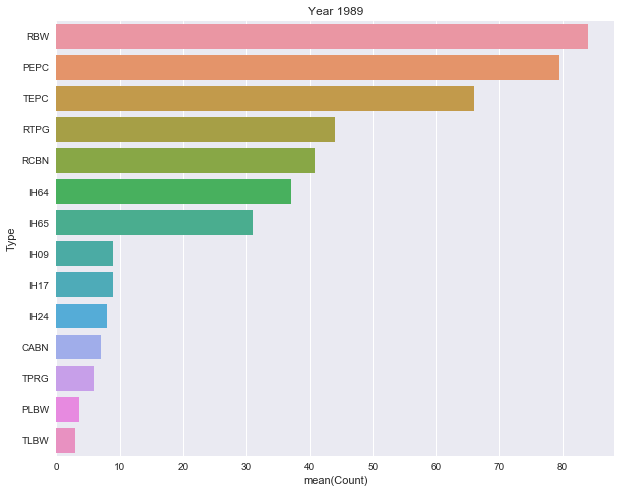

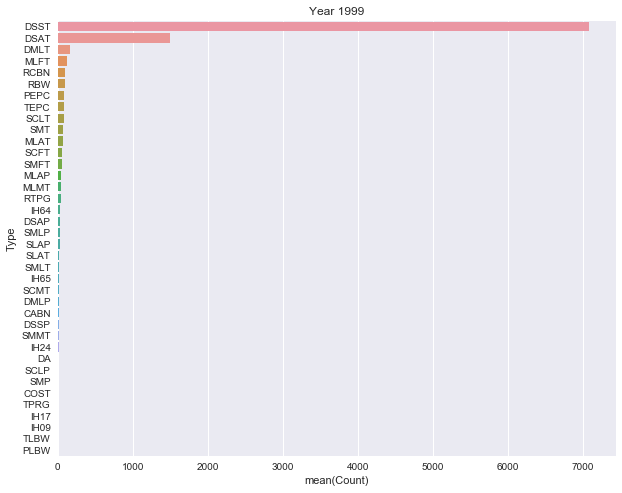

In [37]:
data = healthabr[(healthabr['YEAR'] == '1989')]
types  = data[['TYPE','ESSEX']].groupby(['TYPE'], as_index=False).sum()
types.columns = ['Type','Count']
types = types.sort_values(by='Count',ascending=0)
types = types[(types.Type != 'SHAPES')]
types.head()
sns.barplot(x='Count', y='Type', data=types)
plt.title('Year 1989')
plt.show()

data = healthabr[(healthabr['YEAR'] == '1990')]
types  = data[['TYPE','ESSEX']].groupby(['TYPE'], as_index=False).sum()
types.columns = ['Type','Count']
types = types.sort_values(by='Count',ascending=0)
types = types[(types.Type != 'SHAPES')]
types.head()
sns.barplot(x='Count', y='Type', data=types)
plt.title('Year 1999')
plt.show()

The health data has a large amount of complexity around it's meaning, but it provided a large data set to use for merging and converting.  Data analysis could be completed, the data transposed again back into the original form and merged into another geospatial dataset.

## Summary

Like most things in data analysis, the most time consuming work is getting data into shape to be useable, in this case many columns could be cut off and domain knowledge added to determine what insights could be gathered. Never shortcut on these steps when actually trying to apply the information.